In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
import dgl
import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.method import PGExplainer
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [66]:
Explainability_name = 'PGExplainer'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [67]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [68]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [69]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [70]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [71]:
dataset2 = balanced_train_test_split(dataset)
dataset_PGExplainer = dataset2[0]
print(dataset_PGExplainer)
print(len(dataset_PGExplainer))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


# **GCN MODEL**

In [72]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [73]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [74]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [75]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [76]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # --- add require_grad ---
        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        # --- My: record edge_weight ---
        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        # Otherwise, run both functions in separation.
        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            # For `GNNExplainer`, we require a separate message and aggregate
            # procedure since this allows us to inject the `edge_mask` into the
            # message passing computation scheme.
            if self._explain:
                edge_mask = self.__edge_mask__
                # Some ops add self-loops to `edge_index`. We need to do the
                # same for `edge_mask` (but do not train those).
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [77]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_node, dim_hidden)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))

        out_readout = self.readout(post_conv2, batch)

        out = self.ffn(out_readout)

        return out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

GCN_2l_Model(
  (gconv1): GCNConv(1433, 100)
  (relu1): ReLU()
  (gconv2): GCNConv(1433, 100)
  (relu2): ReLU()
  (readout): IdenticalPool()
  (ffn): Linear(in_features=100, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


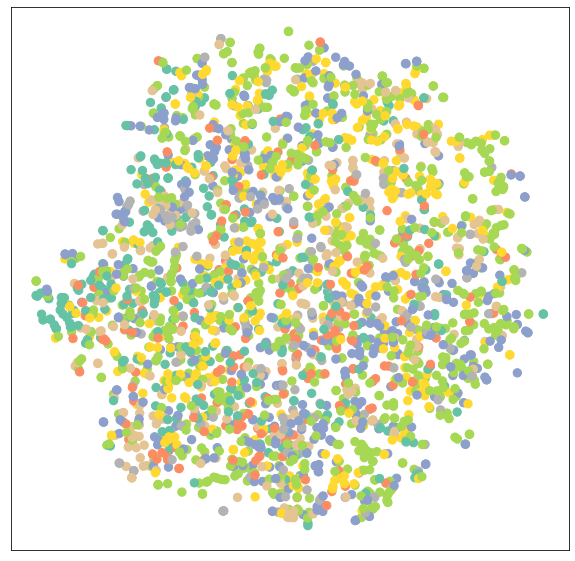

In [78]:
GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, dim_output=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)


In [79]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [80]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [81]:
def loading_model(load_index):
  GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [82]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [83]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_PGExplainer.train_mask], dataset_PGExplainer.y[dataset_PGExplainer.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [84]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [85]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, PGExplainer Model Loss: 1.9335
Epoch: 002, PGExplainer Model Loss: 1.9182
Epoch: 003, PGExplainer Model Loss: 1.8996
Epoch: 004, PGExplainer Model Loss: 1.8777
Epoch: 005, PGExplainer Model Loss: 1.8537
Epoch: 006, PGExplainer Model Loss: 1.8295
Epoch: 007, PGExplainer Model Loss: 1.8071
Epoch: 008, PGExplainer Model Loss: 1.7880
Epoch: 009, PGExplainer Model Loss: 1.7728
Epoch: 010, PGExplainer Model Loss: 1.7607
Epoch: 011, PGExplainer Model Loss: 1.7491
Epoch: 012, PGExplainer Model Loss: 1.7352
Epoch: 013, PGExplainer Model Loss: 1.7185
Epoch: 014, PGExplainer Model Loss: 1.6996
Epoch: 015, PGExplainer Model Loss: 1.6800
Epoch: 016, PGExplainer Model Loss: 1.6609
Epoch: 017, PGExplainer Model Loss: 1.6431
Epoch: 018, PGExplainer Model Loss: 1.6258
Epoch: 019, PGExplainer Model Loss: 1.6077
Epoch: 020, PGExplainer Model Loss: 1.5879
Epoch: 021, PGExplainer Model Loss: 1.5665
Epoch: 022, PGExplainer Model Loss: 1.5442
Epoch: 023, PGExplainer Model Loss: 1.5221
Epoch: 024,

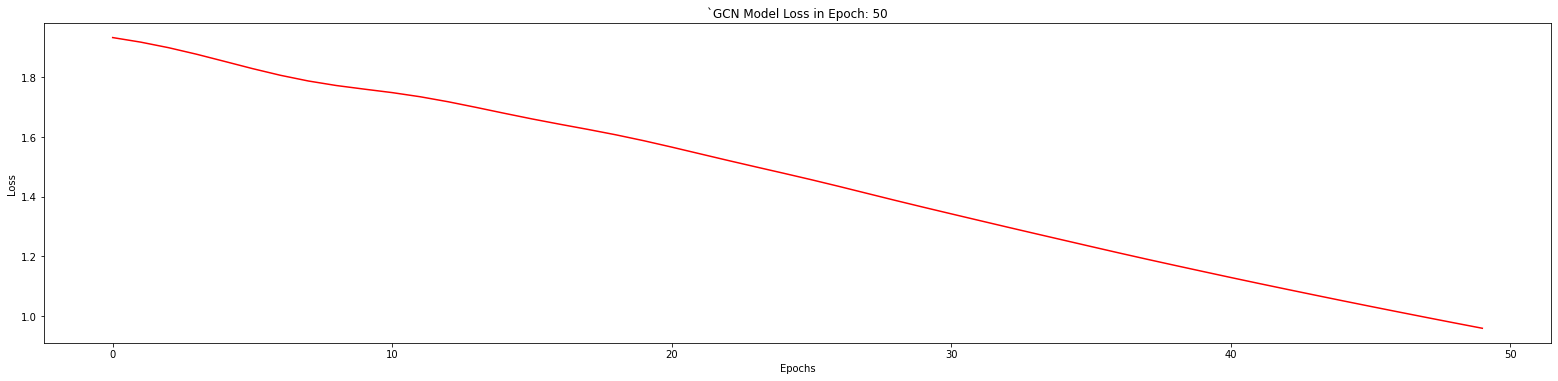

Epoch: 051, PGExplainer Model Loss: 0.9419
Epoch: 052, PGExplainer Model Loss: 0.9245
Epoch: 053, PGExplainer Model Loss: 0.9074
Epoch: 054, PGExplainer Model Loss: 0.8907
Epoch: 055, PGExplainer Model Loss: 0.8743
Epoch: 056, PGExplainer Model Loss: 0.8583
Epoch: 057, PGExplainer Model Loss: 0.8428
Epoch: 058, PGExplainer Model Loss: 0.8276
Epoch: 059, PGExplainer Model Loss: 0.8129
Epoch: 060, PGExplainer Model Loss: 0.7987
Epoch: 061, PGExplainer Model Loss: 0.7848
Epoch: 062, PGExplainer Model Loss: 0.7714
Epoch: 063, PGExplainer Model Loss: 0.7584
Epoch: 064, PGExplainer Model Loss: 0.7459
Epoch: 065, PGExplainer Model Loss: 0.7338
Epoch: 066, PGExplainer Model Loss: 0.7221
Epoch: 067, PGExplainer Model Loss: 0.7109
Epoch: 068, PGExplainer Model Loss: 0.7001
Epoch: 069, PGExplainer Model Loss: 0.6896
Epoch: 070, PGExplainer Model Loss: 0.6795
Epoch: 071, PGExplainer Model Loss: 0.6699
Epoch: 072, PGExplainer Model Loss: 0.6605
Epoch: 073, PGExplainer Model Loss: 0.6516
Epoch: 074,

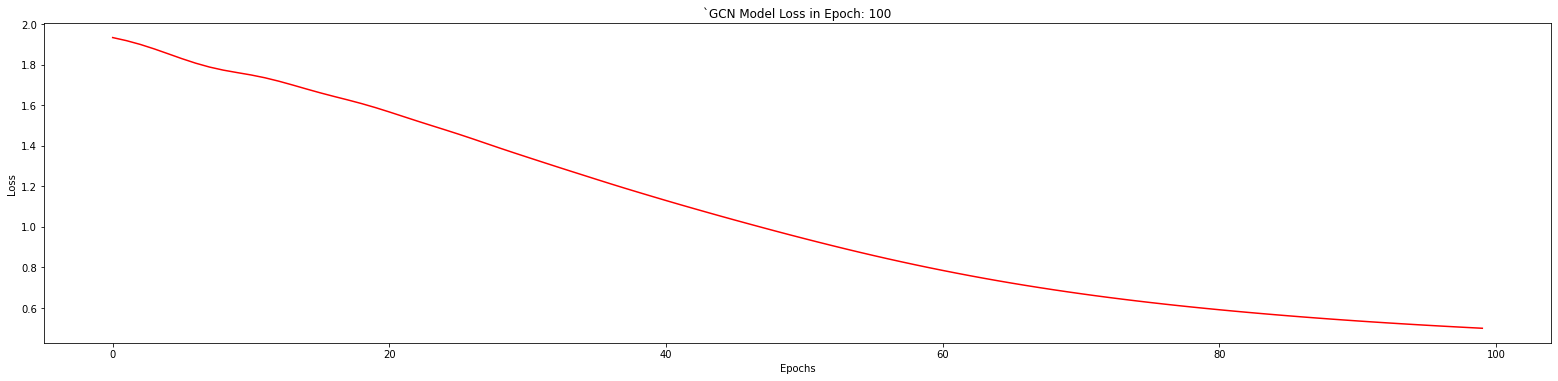

Epoch: 101, PGExplainer Model Loss: 0.4962
Epoch: 102, PGExplainer Model Loss: 0.4929
Epoch: 103, PGExplainer Model Loss: 0.4897
Epoch: 104, PGExplainer Model Loss: 0.4866
Epoch: 105, PGExplainer Model Loss: 0.4836
Epoch: 106, PGExplainer Model Loss: 0.4806
Epoch: 107, PGExplainer Model Loss: 0.4778
Epoch: 108, PGExplainer Model Loss: 0.4750
Epoch: 109, PGExplainer Model Loss: 0.4722
Epoch: 110, PGExplainer Model Loss: 0.4696
Epoch: 111, PGExplainer Model Loss: 0.4670
Epoch: 112, PGExplainer Model Loss: 0.4645
Epoch: 113, PGExplainer Model Loss: 0.4620
Epoch: 114, PGExplainer Model Loss: 0.4596
Epoch: 115, PGExplainer Model Loss: 0.4573
Epoch: 116, PGExplainer Model Loss: 0.4550
Epoch: 117, PGExplainer Model Loss: 0.4528
Epoch: 118, PGExplainer Model Loss: 0.4506
Epoch: 119, PGExplainer Model Loss: 0.4485
Epoch: 120, PGExplainer Model Loss: 0.4464
Epoch: 121, PGExplainer Model Loss: 0.4444
Epoch: 122, PGExplainer Model Loss: 0.4424
Epoch: 123, PGExplainer Model Loss: 0.4404
Epoch: 124,

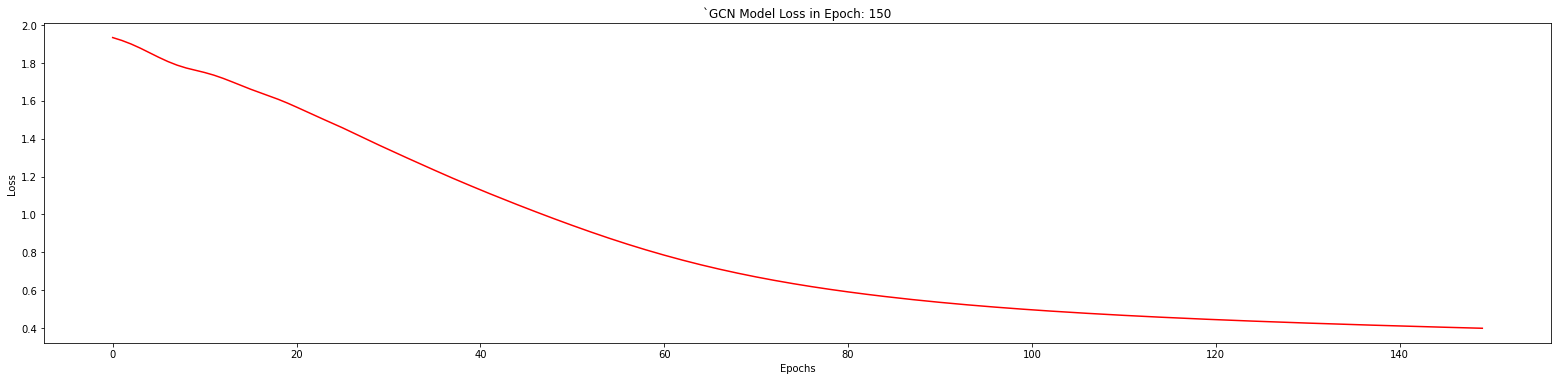

Epoch: 151, PGExplainer Model Loss: 0.3976
Epoch: 152, PGExplainer Model Loss: 0.3963
Epoch: 153, PGExplainer Model Loss: 0.3951
Epoch: 154, PGExplainer Model Loss: 0.3939
Epoch: 155, PGExplainer Model Loss: 0.3926
Epoch: 156, PGExplainer Model Loss: 0.3914
Epoch: 157, PGExplainer Model Loss: 0.3902
Epoch: 158, PGExplainer Model Loss: 0.3890
Epoch: 159, PGExplainer Model Loss: 0.3878
Epoch: 160, PGExplainer Model Loss: 0.3867
Epoch: 161, PGExplainer Model Loss: 0.3856
Epoch: 162, PGExplainer Model Loss: 0.3844
Epoch: 163, PGExplainer Model Loss: 0.3833
Epoch: 164, PGExplainer Model Loss: 0.3821
Epoch: 165, PGExplainer Model Loss: 0.3809
Epoch: 166, PGExplainer Model Loss: 0.3798
Epoch: 167, PGExplainer Model Loss: 0.3787
Epoch: 168, PGExplainer Model Loss: 0.3777
Epoch: 169, PGExplainer Model Loss: 0.3766
Epoch: 170, PGExplainer Model Loss: 0.3756
Epoch: 171, PGExplainer Model Loss: 0.3745
Epoch: 172, PGExplainer Model Loss: 0.3735
Epoch: 173, PGExplainer Model Loss: 0.3723
Epoch: 174,

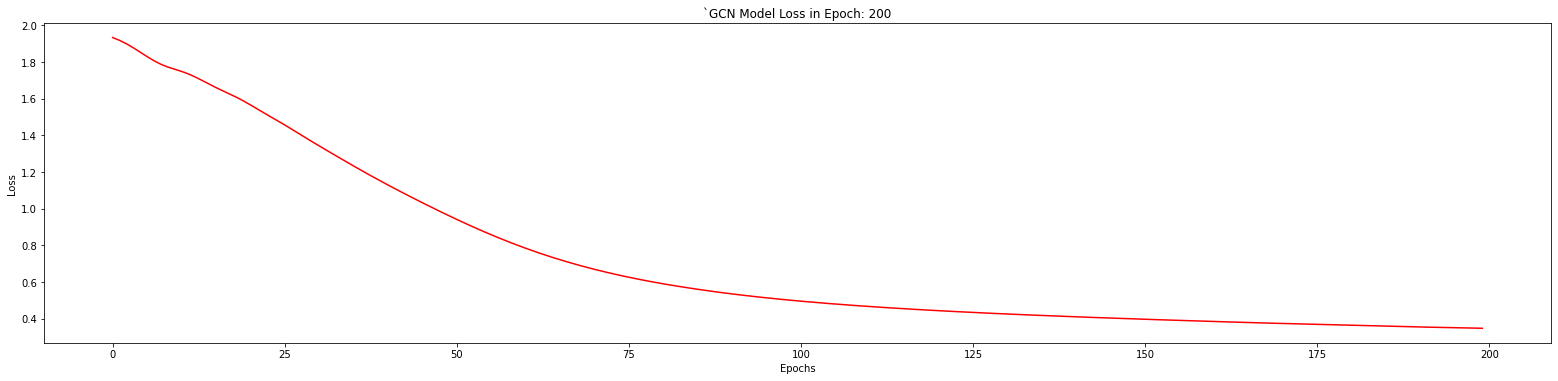

In [86]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [87]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_PGExplainer.test_mask] == dataset_PGExplainer.y[dataset_PGExplainer.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_PGExplainer.test_mask.sum())
  return GCN_Model_test_acc

In [88]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8703


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


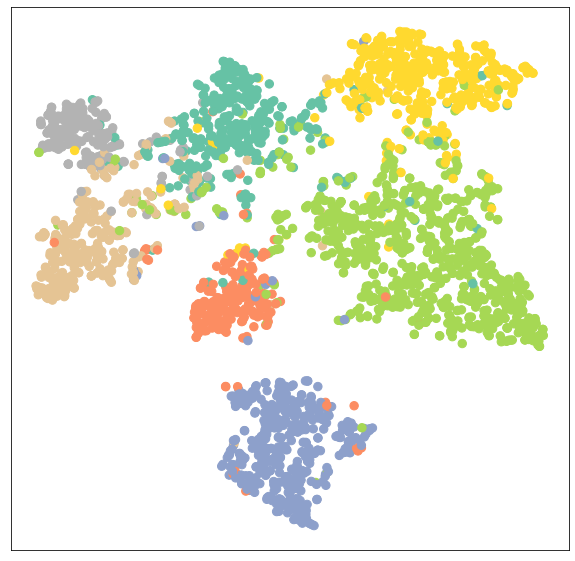

In [95]:
GCN_Model.eval()

GCN_Model_test_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(GCN_Model_test_out, color = dataset_PGExplainer.y)

# **Index List of each Category**

In [111]:
Train_Nodes_Index_List = []
for i in range(len(dataset_PGExplainer.x)):
  if dataset_PGExplainer.train_mask[i]:
    Train_Nodes_Index_List.append(i)

Test_Nodes_Index_List = []
for i in range(len(dataset_PGExplainer.x)):
  if dataset_PGExplainer.test_mask[i]:
    Test_Nodes_Index_List.append(i)

In [112]:
print(Train_Nodes_Index_List)
print(Test_Nodes_Index_List)

[0, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 51, 52, 54, 55, 57, 59, 61, 62, 63, 64, 66, 67, 69, 70, 71, 73, 74, 75, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 110, 112, 114, 115, 116, 117, 118, 120, 121, 123, 127, 128, 129, 130, 131, 133, 135, 136, 138, 139, 140, 142, 145, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 172, 174, 175, 177, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 196, 197, 198, 200, 202, 204, 205, 207, 209, 210, 211, 212, 215, 216, 217, 218, 219, 220, 221, 225, 227, 228, 230, 231, 234, 236, 237, 239, 240, 241, 242, 244, 246, 247, 248, 249, 250, 254, 255, 256, 257, 259, 261, 262, 263, 265, 266, 268, 269, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 294, 295, 296, 297, 299, 

In [113]:
print(len(dataset2.data))
print(len(dataset_PGExplainer.x))
print(dataset_PGExplainer.keys)
print('whole dataset: ', len(dataset_PGExplainer.train_mask))
print('training dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print('test dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))


6
2708
['test_mask', 'edge_index', 'val_mask', 'train_mask', 'y', 'x']
whole dataset:  2708
training dataset:  1891
test dataset:  817


In [114]:
print(len(Train_Nodes_Index_List))
print(len(Test_Nodes_Index_List))
print()
print(Train_Nodes_Index_List)
print(Test_Nodes_Index_List)

1891
817

[0, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 51, 52, 54, 55, 57, 59, 61, 62, 63, 64, 66, 67, 69, 70, 71, 73, 74, 75, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 110, 112, 114, 115, 116, 117, 118, 120, 121, 123, 127, 128, 129, 130, 131, 133, 135, 136, 138, 139, 140, 142, 145, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 172, 174, 175, 177, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 196, 197, 198, 200, 202, 204, 205, 207, 209, 210, 211, 212, 215, 216, 217, 218, 219, 220, 221, 225, 227, 228, 230, 231, 234, 236, 237, 239, 240, 241, 242, 244, 246, 247, 248, 249, 250, 254, 255, 256, 257, 259, 261, 262, 263, 265, 266, 268, 269, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 294, 295, 296, 

In [115]:
print(Train_Nodes_Index_List)
print(len(Train_Nodes_Index_List))

print(Test_Nodes_Index_List)
print(len(Test_Nodes_Index_List))

#print(len(dataset_PGExplainer.x[0]))

[0, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 51, 52, 54, 55, 57, 59, 61, 62, 63, 64, 66, 67, 69, 70, 71, 73, 74, 75, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 110, 112, 114, 115, 116, 117, 118, 120, 121, 123, 127, 128, 129, 130, 131, 133, 135, 136, 138, 139, 140, 142, 145, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 172, 174, 175, 177, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 196, 197, 198, 200, 202, 204, 205, 207, 209, 210, 211, 212, 215, 216, 217, 218, 219, 220, 221, 225, 227, 228, 230, 231, 234, 236, 237, 239, 240, 241, 242, 244, 246, 247, 248, 249, 250, 254, 255, 256, 257, 259, 261, 262, 263, 265, 266, 268, 269, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 294, 295, 296, 297, 299, 

# **Features of Each Category**

In [116]:
training_nodes_fetures = dataset_PGExplainer.x[Train_Nodes_Index_List]
test_nodes_features = dataset_PGExplainer.x[Test_Nodes_Index_List]

print(len(training_nodes_fetures))
print(len(test_nodes_features))

#print(training_nodes)

training_nodes = training_nodes_fetures.detach().cpu().numpy()
Training_Nodes_Features = training_nodes.tolist()

test_nodes = test_nodes_features.detach().cpu().numpy()
Test_Nodes_Features = test_nodes.tolist()


print(len(Training_Nodes_Features))
print(len(Test_Nodes_Features))

1891
817
1891
817


# **Eadges of each Node**
Training

In [117]:
Edges_Training_Dataset = []
first_node_edge_training_dataset = []
second_node_edge_training_dataset = []
scnd_node_edge_training_dataset = []

print("Number of Whole Edges: ", len(dataset_PGExplainer.edge_index[0]))

for node_index in Train_Nodes_Index_List:
  index = (dataset_PGExplainer.edge_index[0] == node_index).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_training_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_training_dataset.extend(B)
  scnd_node_edge_training_dataset.append(B)


print(len(first_node_edge_training_dataset))
print(len(second_node_edge_training_dataset))
print(first_node_edge_training_dataset)
print(second_node_edge_training_dataset)

Number of Whole Edges:  10556
7233
7233
[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 6, 6, 6, 6, 8, 8, 8, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 21, 21, 22, 22, 22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 27, 27, 27, 27, 29, 29, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 45, 45, 45, 48, 48, 48, 48, 48, 48, 48, 48, 48, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 57, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 62, 63, 64, 64, 64, 66, 67, 67, 67, 69, 69, 69, 69, 69, 69, 69, 70, 70, 71, 71, 71, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 78,

In [118]:
Edges_Training_Dataset.append(first_node_edge_training_dataset)
Edges_Training_Dataset.append(second_node_edge_training_dataset)

In [119]:
print("Number of Training Edges: ", len(Edges_Training_Dataset[0]))

Number of Training Edges:  7233


# **Eadges of each Node**
Test

In [120]:
Edges_Test_Dataset = []

first_node_edge_test_dataset = []
second_node_edge_test_dataset = []

#print(len(dataset_PGExplainer.edge_index[0]))

for node in Test_Nodes_Index_List:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_test_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_test_dataset.extend(B)

print(len(first_node_edge_test_dataset))
print(len(second_node_edge_test_dataset))
print(first_node_edge_test_dataset)
print(second_node_edge_test_dataset)

3323
3323
[5, 5, 5, 7, 9, 9, 15, 15, 15, 15, 19, 20, 20, 20, 20, 20, 26, 26, 26, 26, 26, 28, 31, 46, 46, 47, 47, 49, 49, 50, 53, 53, 53, 56, 56, 56, 56, 58, 60, 60, 60, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 68, 68, 68, 72, 72, 76, 76, 76, 77, 77, 80, 80, 80, 87, 87, 87, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 99, 99, 99, 99, 99, 99, 103, 103, 103, 103, 103, 103, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 111, 111, 111, 111, 111, 111, 113, 113, 113, 119, 119, 119, 119, 119, 119, 122, 122, 122, 122, 124, 124, 124, 124, 124, 125, 125, 126, 126, 126, 126, 126, 126, 132, 132, 132, 132, 132, 134, 137, 137, 137, 137, 141, 141, 141, 143, 143, 143, 144, 144, 144, 144, 146, 146, 146, 146, 146, 148, 148, 148, 148, 148, 159, 159, 168, 168, 168, 169, 169, 173, 173, 173, 173, 176, 176, 176, 178, 182, 182, 192, 195, 195, 199, 199, 201, 201, 201, 201, 201, 201, 201, 203, 203, 203,

In [121]:
Edges_Test_Dataset.append(first_node_edge_test_dataset)
Edges_Test_Dataset.append(second_node_edge_test_dataset)

In [122]:
print("Number of Test Edges: ", len(Edges_Test_Dataset[0]))

Number of Test Edges:  3323


# **Labels of each Category**

In [123]:
training_labels = dataset_PGExplainer.y[Train_Nodes_Index_List]
test_labels = dataset_PGExplainer.y[Test_Nodes_Index_List]


print(len(training_labels))
print(len(test_labels))

print(training_labels)

Training_Labels = training_labels.detach().cpu().numpy()
Training_Labels = training_labels.tolist()

Test_Labels = test_labels.detach().cpu().numpy()
Test_Labels = test_labels.tolist()


print(len(Training_Labels))
print(len(Test_Labels))

1891
817
tensor([3, 4, 4,  ..., 3, 3, 3])
1891
817


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


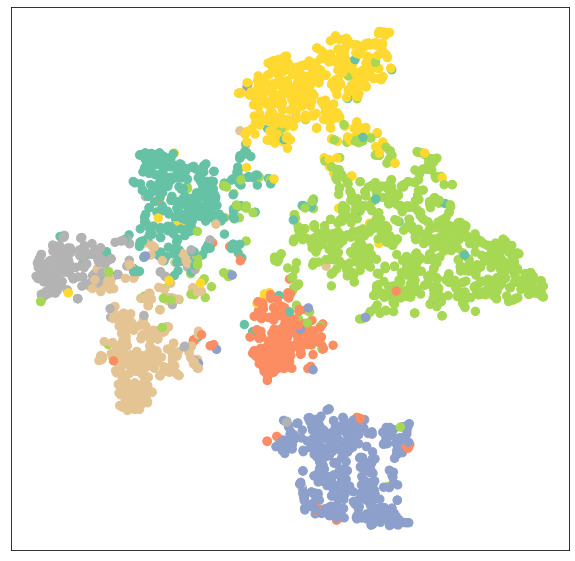

In [124]:
out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)

# **PGExplainer**


In [90]:
import os
import os.path as osp

import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [126]:
from dig.xgraph.method import PGExplainer
explainer_epoch = 1
PG_Explainer = PGExplainer(GCN_Model, in_channels=300, device=device, explain_graph=False, num_hops=1, epochs=explainer_epoch)


## **Explainer is trained ONLY on Training Set**

In [33]:
PG_Explainer.train_explanation_network(dataset2)

100%|██████████| 1891/1891 [00:00<00:00, 27384.32it/s]
1891it [09:20,  3.37it/s]

Epoch: 0 | Loss: 0.42599614507000105
training time is 560.61s


In [34]:
torch.save(PG_Explainer.state_dict(), "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + "PG_Explainer_" + "trained on " + str(explainer_epoch) + " Epoch" + ".pt")


In [127]:
state_dict = torch.load("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + "PG_Explainer_" + "trained on " + str(explainer_epoch) + " Epoch" + ".pt")
PG_Explainer.load_state_dict(state_dict)

<All keys matched successfully>

In [128]:
explainer_model_state = PG_Explainer.state_dict()

In [129]:
print(len(explainer_model_state))
print(explainer_model_state.keys())

12
odict_keys(['model.gconv1.bias', 'model.gconv1.weight', 'model.gconv1.lin.weight', 'model.gconv2.bias', 'model.gconv2.weight', 'model.gconv2.lin.weight', 'model.ffn.weight', 'model.ffn.bias', 'elayers.0.0.weight', 'elayers.0.0.bias', 'elayers.1.weight', 'elayers.1.bias'])


## **Training Edge Masks**

In [136]:
Train_Edge_Masks = []
for i in range(len(Train_Nodes_Index_List)):
  with torch.no_grad():
    walks, masks, related_preds = PG_Explainer(dataset_PGExplainer.x, dataset_PGExplainer.edge_index, node_idx=Train_Nodes_Index_List[i], y=dataset_PGExplainer.y)
    print(i, "   ", Train_Nodes_Index_List[i])
    #print(masks[0].detach().numpy().tolist())
    Train_Edge_Masks.append(masks[0].detach().numpy().tolist())



0     0
1     1
2     2
3     3
4     4
5     6
6     8
7     10
8     11
9     12
10     13
11     14
12     16
13     17
14     18
15     21
16     22
17     23
18     24
19     25
20     27
21     29
22     30
23     32
24     33
25     34
26     35
27     36
28     37
29     38
30     39
31     40
32     41
33     42
34     43
35     44
36     45
37     48
38     51
39     52
40     54
41     55
42     57
43     59
44     61
45     62
46     63
47     64
48     66
49     67
50     69
51     70
52     71
53     73
54     74
55     75
56     78
57     79
58     81
59     82
60     83
61     84
62     85
63     86
64     88
65     89
66     90
67     91
68     92
69     93
70     95
71     96
72     97
73     98
74     100
75     101
76     102
77     104
78     105
79     106
80     107
81     108
82     110
83     112
84     114
85     115
86     116
87     117
88     118
89     120
90     121
91     123
92     127
93     128
94     129
95     130
96     131
97     133
98     135
99

In [137]:
print(len(Train_Edge_Masks))
print(Train_Edge_Masks[0])

1891
[0.617714524269104, 0.6164939403533936, 0.6164939403533936, 0.617714524269104, 0.6164939403533936, 0.6155837178230286, 0.6164939403533936, 0.6155837178230286]


In [138]:

sum=0
for mask in Train_Edge_Masks:
  sum = sum + len(mask)
print(sum)
print(len(dataset_PGExplainer.edge_index[0]))

21096
10556


In [139]:
print(len(Train_Edge_Masks), sum)

1891 21096


In [140]:
print(len(Train_Edge_Masks))
print(len(scnd_node_edge_training_dataset))

1891
1891


In [141]:
for i in range(len(Train_Edge_Masks)):
  print(len(Train_Edge_Masks[i]), "   ", len(scnd_node_edge_training_dataset[i]))

8     3
6     3
10     5
2     1
24     5
12     4
6     3
4     2
6     2
14     4
4     2
16     5
8     4
14     5
10     5
4     2
20     5
2     1
28     7
8     4
12     4
4     2
14     6
8     4
26     9
2     1
12     3
26     8
6     3
12     4
16     7
6     3
16     4
4     2
16     6
8     3
16     6
20     9
18     6
16     5
4     2
30     12
2     1
30     10
12     5
2     1
2     1
10     3
2     1
6     3
24     7
6     2
8     3
44     12
32     9
28     6
6     3
4     2
12     4
4     2
4     2
24     5
6     3
10     4
126     36
32     10
18     4
22     6
6     2
8     4
76     21
2     1
6     2
2     1
4     2
6     3
24     8
14     4
14     4
2     1
12     4
8     3
12     5
14     4
8     3
2     1
4     2
6     2
58     19
20     5
24     7
16     4
2     1
8     4
4     2
8     3
4     2
28     9
8     3
2     1
8     3
28     8
4     2
16     5
24     6
4     2
8     4
6     3
8     4
10     4
28     6
52     12
38     7
30     6
12     4
10     4
32  

## **check**

In [110]:
count_edges_per_node_trainingset = 0

for node_index in Train_Nodes_Index_List:
  idx = [i for i,x in enumerate(first_node_edge_training_dataset) if x == node_index]
  count_edges_per_node_trainingset = count_edges_per_node_trainingset + len(idx)
print(count_edges_per_node_trainingset)


7233


In [59]:
Tr_Edge_Masks = []
for i in range(len(Train_Nodes_Index_List)):
  with torch.no_grad():
    walks, masks, related_preds = PG_Explainer(dataset_PGExplainer.x, dataset_PGExplainer.edge_index, node_idx=Train_Nodes_Index_List[i], y=dataset_PGExplainer.y)
    #print(i, "   ", Train_Nodes_Index_List[i], "    ", "masks: ", masks)
    #print(i, "   ", Train_Nodes_Index_List[i], "    ", "masks: ", masks[0])
    Tr_Edge_Masks.append(masks[0].detach().numpy().tolist())
    print(masks[0].detach().numpy().tolist())
    if i == 10:
      break

[0.617714524269104, 0.6164939403533936, 0.6164939403533936, 0.617714524269104, 0.6164939403533936, 0.6155837178230286, 0.6164939403533936, 0.6155837178230286]
[0.5971864461898804, 0.596497654914856, 0.5954714417457581, 0.5971864461898804, 0.596497654914856, 0.5954714417457581]
[0.6084897518157959, 0.6084897518157959, 0.6115087270736694, 0.6105313301086426, 0.6098306179046631, 0.6181086301803589, 0.6115087270736694, 0.6105313301086426, 0.6098306179046631, 0.6181086301803589]
[0.6041325330734253, 0.6019363403320312, 0.6008068323135376, 0.6013637781143188, 0.6030023097991943, 0.6041325330734253, 0.6041325330734253, 0.6051959991455078, 0.6019363403320312, 0.6041325330734253, 0.6008068323135376, 0.6013637781143188, 0.6030023097991943, 0.6008068323135376, 0.6008068323135376, 0.600233793258667, 0.6013637781143188, 0.6013637781143188, 0.600233793258667, 0.6024304032325745, 0.6030023097991943, 0.6051959991455078, 0.6030023097991943, 0.6024304032325745]
[0.6162746548652649, 0.6162746548652649]
[

In [60]:
print(first_node_edge_training_dataset)
print(scnd_node_edge_training_dataset)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 7, 8, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 12, 12, 14, 14, 14, 14, 14, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 21, 21, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 34, 35, 35, 35, 37, 37, 37, 38, 38, 38, 38, 40, 40, 40, 43, 43, 43, 43, 43, 43, 46, 46, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 58, 60, 60, 60, 61, 61, 61, 61, 61, 62, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 76, 76, 76, 78, 78, 78, 79, 79, 80, 80, 80, 81, 81, 81, 81, 82, 82, 83, 83, 84, 84, 84, 84, 84, 86, 86, 86, 86, 87, 87, 87, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 9

In [61]:
print(first_node_edge_test_dataset)

[3, 5, 5, 5, 6, 6, 6, 6, 13, 13, 15, 15, 15, 15, 16, 16, 16, 16, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 26, 26, 26, 26, 26, 31, 33, 33, 33, 33, 33, 33, 33, 33, 33, 36, 36, 36, 36, 36, 36, 36, 36, 39, 39, 39, 39, 39, 39, 39, 41, 41, 41, 41, 42, 42, 44, 44, 44, 45, 45, 45, 45, 45, 45, 50, 57, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 70, 70, 71, 71, 71, 77, 77, 85, 85, 85, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 93, 93, 93, 93, 98, 106, 107, 107, 107, 107, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 111, 111, 111, 111, 111, 111, 113, 113, 113, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 124, 124, 124, 124, 124, 128, 128, 128, 128, 130, 130, 130, 131, 131, 137, 137, 137, 137, 140, 140, 143, 143, 143, 147, 147, 148, 148, 148, 148, 148, 151, 151

In [62]:
for lst in Tr_Edge_Masks:
  print(len(lst))

8
6
10
24
2
6
6
4
6
14
16
